In [ ]:
# Author: Amara J. Moosa
# Date:   02/05/2018
# Purpose: IST-718 Lab 2 Assignment
#--------------------------------------------------------------------------------------------------------------------------------
# Chane History
#--------------------------------------------------------------------------------------------------------------------------------
# Name  Date         Purpose
#--------------------------------------------------------------------------------------------------------------------------------
# AJM   02/05/2018   Initial creation
# AJM   02/07/2018   Loaded census and zip code data
# AJM   02/09/2018   Fit ARIMA model to data
# AJM   02/11/2018   Fitted the ARIMA model to include the residual and bias
#--------------------------------------------------------------------------------------------------------------------------------

In [11]:
# Load the required packages for data modeling and analysis
from pandas import Series
import pandas as pd # Data frame object
import numpy as np # Math and numeric package
import matplotlib.pyplot as plt # use for graphical plotting 
import datetime # For datetime manipulation
from statsmodels.tsa.arima_model import ARIMA # time series modeling
from statsmodels.tsa.stattools import grangercausalitytests as granger
from pandas import TimeGrouper # For grouping dataset by time component.
from pandas import DataFrame 
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
sns.set()
plt.style.use('seaborn-colorblind')

In [2]:
# load base data available from Zillow
# (files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv)
# This file is very large so I decided to put the data loading int it separate cell
df_zillow = pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv') # Load the dataset

# Peek at the data
print('\nShowing sample zillow data')
print(df_zillow.head())

# Make minor changes to the zillow data before merging
df_zillow.rename(columns={'RegionID':'ZipCode'}, inplace = True) # Rename the region id to zip code
df_zillow.ZipCode.astype('object') # Convert the zipcode to an object

# The dataset that we have is not tidy, we need to transform the data as follows:
# a) Move the dates into their own variables
# b) Move the values in the data columns as their own variabels
df_zillow = pd.melt(df_zillow, id_vars=['ZipCode','RegionName','City','State','Metro','CountyName',\
                                        'SizeRank'],var_name ='Date', value_name ='HomePrice')

# Get the geocode dataset: Dataset from https://gist.github.com/erichurst/7882666
df_uszipcodedata = pd.read_table('USZipCodesData.txt', sep = ',')

# Peek at the zip code data
print('\nShowing sample zip code data')
print(df_uszipcodedata.head())

# Do minor changes to the data before merging
df_uszipcodedata.rename(columns={'ZIP':'ZipCode', 'LAT':'Latitude', 'LNG':' Longitude'}, inplace=True)
df_uszipcodedata.ZipCode.astype('object')

# Load the 2010 US Census data from https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv
df_census_data = pd.read_csv('2010_Census_Population_By_Zipcode.csv')

# Peek at the census data before merging
print('\nShowing sameple census data')
print(df_census_data.head())

# Do some minor changes to the data before merging
df_census_data.ZipCode.astype('object')

# Merge Zillow and geocode data together.
# Merge the census and geo data 
df_census_geo_data = pd.merge(left = df_census_data, right = df_uszipcodedata, how = 'left', 
                              left_on ='ZipCode', right_on='ZipCode')

# Peek at the census geo data
print('\nShowing sample census geo data')
print(df_census_geo_data.head())

# Merge the census geo data with the df_1997_2013 home file data
df_home_value_data =  pd.merge(left = df_zillow, right = df_census_geo_data, how ='left',
                              left_on='ZipCode', right_on='ZipCode')

# Check to see if the data was merge
print('\nShowing the structure of the merge data: ', df_home_value_data.shape)

# Check te structure of the dataset
print('\nShowing column information:')
print(df_home_value_data.info())

# Check the first 5 observations of the dataset to make sure it was read and to also see the type of
# values.
print('n\Top 5 observations of the dataset.')
print(df_home_value_data.head())

#Check the last 5 observation of the dataset to make sure it was read and to also see the type of
print('\nLower 5 observations of the dataset.')
print(df_home_value_data.tail())


Showing sample zillow data
   RegionID  RegionName      City State     Metro CountyName  SizeRank  \
0     84654       60657   Chicago    IL   Chicago       Cook         1   
1     84616       60614   Chicago    IL   Chicago       Cook         2   
2     93144       79936   El Paso    TX   El Paso    El Paso         3   
3     84640       60640   Chicago    IL   Chicago       Cook         4   
4     61807       10467  New York    NY  New York      Bronx         5   

    1996-04   1996-05   1996-06   ...     2017-03  2017-04  2017-05  2017-06  \
0  420800.0  423500.0  426200.0   ...     1087500  1080200  1073700  1064100   
1  542400.0  546700.0  551700.0   ...     1526300  1527000  1524600  1516600   
2   70900.0   71200.0   71100.0   ...      114000   113800   114000   114000   
3  298200.0  297400.0  295300.0   ...      735700   728400   726800   724900   
4       NaN       NaN       NaN   ...      392700   396300   399100   401000   

   2017-07  2017-08  2017-09  2017-10  2017-11

In [3]:
# 1.2) Data—clean as appropriate.

#Check for missing data and drop if any
# select dates with complete data on all four series
#if  df_home_value_data.isnull().any().sum() != 0:
    #df_home_value_data = df_home_value_data.dropna()
#print('\nHow many missing data we have?: ', df_home_value_data.isnull().any().sum())    

# Check the first 5 observations of the dataset to make sure it was read and to also see the type of
# values.
print('\nTop 5 observations of the dataset.')
print(df_home_value_data.head())

#Check the last 5 observation of the dataset to make sure it was read and to also see the type of
print('\nLower 5 observations of the dataset.')
print(df_home_value_data.tail())      
    
# Convert the date fields to datetime
df_home_value_data.Date = pd.to_datetime(df_home_value_data.Date, errors = 'coerce')

print('\nShowing sample of the date index object.')
print(df_home_value_data.head())

# Convert the values to the correct data type before we can start analyzing it.
df_home_value_data.RegionName.astype('object')
df_home_value_data.HomePrice.astype('float32')

# create data frames indexed by date
df_home_value_data.set_index('Date', inplace=True)

# Check the index level
print('\nShowing the index levels: ', df_home_value_data.index)

# Check te structure of the dataset
print('\nShowing column information:')
print(df_home_value_data.info())

# Check the structure of the dataset
print('\nShowing the number of rows and columns: ', df_home_value_data.shape)

# Check the dataset again
print('\nShowing the single family dataset')
print(df_home_value_data.head())


Top 5 observations of the dataset.
   ZipCode  RegionName      City State     Metro CountyName  SizeRank  \
0    84654       60657   Chicago    IL   Chicago       Cook         1   
1    84616       60614   Chicago    IL   Chicago       Cook         2   
2    93144       79936   El Paso    TX   El Paso    El Paso         3   
3    84640       60640   Chicago    IL   Chicago       Cook         4   
4    61807       10467  New York    NY  New York      Bronx         5   

      Date  HomePrice  Population   Latitude   Longitude  
0  1996-04   420800.0      2689.0  38.876439 -111.670908  
1  1996-04   542400.0         NaN        NaN         NaN  
2  1996-04    70900.0         NaN        NaN         NaN  
3  1996-04   298200.0       121.0  39.496888 -112.388639  
4  1996-04        NaN         NaN        NaN         NaN  

Lower 5 observations of the dataset.
         ZipCode  RegionName             City State      Metro    CountyName  \
4008433    99074       97102        Arch Cape    OR  


Showing summary statistics for home prices
count   3616517.0000
mean     207979.5835
std      204044.4107
min       16700.0000
25%      102300.0000
50%      149500.0000
75%      239100.0000
max     7313400.0000
Name: HomePrice, dtype: float64


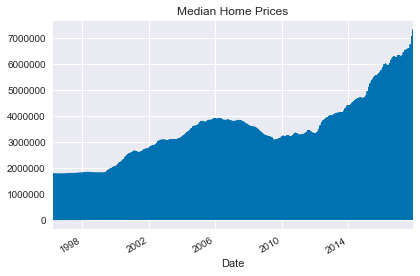

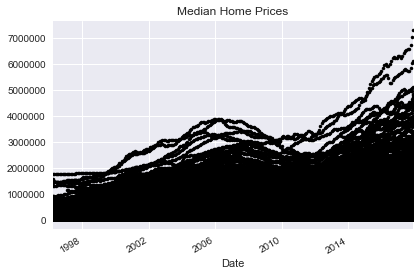

\Display the yearly median home prices
Date
1996-12-31   105000.0000
1997-12-31   107100.0000
1998-12-31   111300.0000
1999-12-31   117000.0000
2000-12-31   123900.0000
Freq: A-DEC, Name: HomePrice, dtype: float64


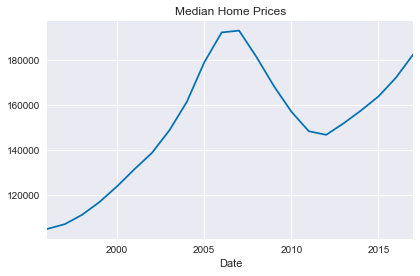

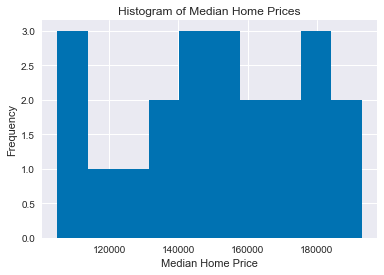

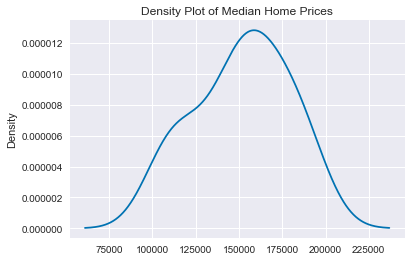

In [12]:
# 1.3) Provide an initial data analysis.

# Suppress scientific notation for calculated values.
pd.options.display.float_format = '{:.4f}'.format

# summary statistics of time series
print('\nShowing summary statistics for home prices')
print(df_home_value_data.HomePrice.describe())

# line plots of time series of the home price variable
df_home_value_data.HomePrice.plot()
plt.title('Median Home Prices')
plt.tight_layout()
plt.show()

# The line plot is too dense, I am going to change it to dot plot
df_home_value_data.HomePrice.plot(style='k.')
plt.title('Median Home Prices')
plt.tight_layout()
plt.show()

# It is still hard to see the trend, I am going to resample the data to yearly values and plot
series = df_home_value_data.HomePrice
resample = series.resample('A')
yearly_median_sales = resample.median()

# Show the resampled data
print('\Display the yearly median home prices')
print(yearly_median_sales.head())

# Plot the yearly median home prices
yearly_median_sales.plot()
plt.title('Median Home Prices')
plt.tight_layout()
plt.show()

# Histogram of median home prices
yearly_median_sales.hist()
plt.title('Histogram of Median Home Prices')
plt.ylabel('Frequency')
plt.xlabel('Median Home Price')
plt.show()

# Density plots of time series
yearly_median_sales.plot(kind = 'kde')
plt.title('Density Plot of Median Home Prices')
plt.show()

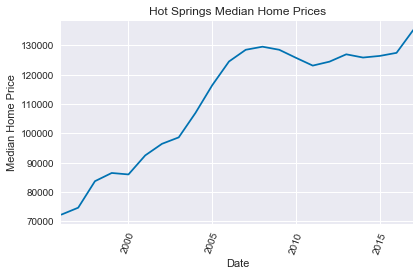

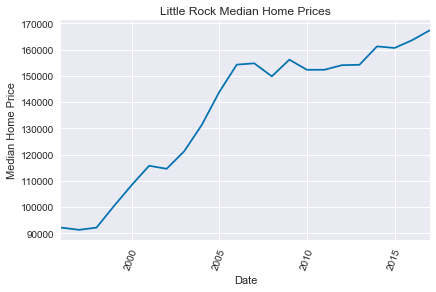

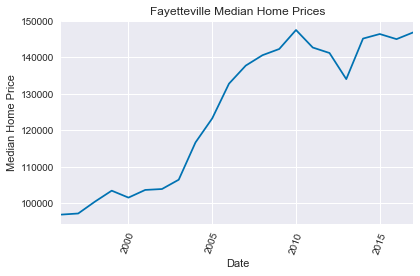

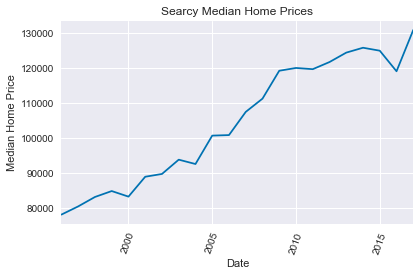


Displaying the structure of the data 1997-2013:  (3133032, 11)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Diplaying the sample average home price by metro
                     HomePrice
Date       ZipCode            
1997-01-01 58196   110500.0000
           58197   158200.0000
           58200   102600.0000
           58201   130400.0000
           58202   114900.0000


In [13]:
# 2.1 Develop time series plots for the following Arkansas metro areas:
# a) Hot Springs
# b) Little Rock
# c) Fayetteville
# d) Searcy

# Create the datasets for plotting. I am going to downsample at the year level and get the median values

# Hot Springs Median Home Prices
hp_ts = df_home_value_data[df_home_value_data.City == 'Hot Springs']
hp_ts_price = hp_ts['HomePrice']
hp_ts_yearly_median_sales = hp_ts_price.resample('A').median()

# Plot the median value
hp_ts_yearly_median_sales.plot()
plt.title('Hot Springs Median Home Prices')
plt.ylabel('Median Home Price')
plt.xticks(rotation='70')
plt.tight_layout()
plt.show()

# Little Roce Median Home Prices
lr_ts = df_home_value_data[df_home_value_data.City == 'Little Rock']
lr_ts_price = lr_ts['HomePrice']
lr_ts_yearly_median_sales = lr_ts_price.resample('A').median()

# Plot the median value
lr_ts_yearly_median_sales.plot()
plt.title('Little Rock Median Home Prices')
plt.ylabel('Median Home Price')
plt.xticks(rotation='70')
plt.tight_layout(pad = 0.4, w_pad = 0.4, h_pad = 1.0)
plt.show()

# Fayetteville Median Home Prices
f_ts = df_home_value_data[df_home_value_data.City == 'Fayetteville']
f_ts_price = f_ts['HomePrice']
f_ts_yearly_median_sales = f_ts_price.resample('A').median()

# Plot the median value
f_ts_yearly_median_sales.plot()
plt.title('Fayetteville Median Home Prices')
plt.ylabel('Median Home Price')
plt.xticks(rotation='70')
plt.tight_layout()
plt.show()

# Searcy Median Home Prices
s_ts = df_home_value_data[df_home_value_data.City == 'Searcy']
s_price = s_ts['HomePrice']
s_ts_yearly_median_sales = s_price.resample('A').median()

# Plot the median value
s_ts_yearly_median_sales.plot()
plt.title('Searcy Median Home Prices')
plt.ylabel('Median Home Price')
plt.xticks(rotation='70')
plt.tight_layout()
plt.show()

# 2.2. Present all values from 1997 to 2013.
# Resample the value at the annual level
df_1997_2013 = df_home_value_data['1997':'2013']
print('\nDisplaying the structure of the data 1997-2013: ', df_1997_2013.shape)

# Create a data frame at the zip code level
metro_level = df_1997_2013[['ZipCode', 'HomePrice']]
metro_level['ZipCode'] = metro_level['ZipCode'].astype('object')
reindexed = metro_level.reset_index()  # Remove the date index 
metro_level_idx = reindexed.set_index(['Date','ZipCode'])  # Add the new index by date and zip
avg_metro = metro_level_idx.groupby(['Date','ZipCode']).mean()# Average at the metro-area level.

# Take a peek at it.
print('\nDiplaying the sample average home price by metro')
print(avg_metro.head())

In [14]:
# 3.5) Develop model for forecasting average median housing value for 2014.
# 3.5.1) separate out a validation dataset
# The 'MS' string groups the data in buckets by start of the month
series = avg_metro.resample('MS', level =0).mean()

split_point = len(series) - 3
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 201, Validation 3


In [15]:
# 3.5.2) Evaluate persistence model on time series
# load data
series = Series.from_csv('dataset.csv', header = 0)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=215197.344, Expected=215072
>Predicted=215072.281, Expected=214490
>Predicted=214490.203, Expected=213655
>Predicted=213654.562, Expected=210073
>Predicted=210072.719, Expected=209100
>Predicted=209100.109, Expected=208107
>Predicted=208106.797, Expected=207307
>Predicted=207306.781, Expected=206548
>Predicted=206548.156, Expected=205784
>Predicted=205783.828, Expected=204842
>Predicted=204841.938, Expected=204134
>Predicted=204134.375, Expected=203401
>Predicted=203400.922, Expected=202767
>Predicted=202767.141, Expected=202221
>Predicted=202221.375, Expected=201637
>Predicted=201636.750, Expected=200728
>Predicted=200727.719, Expected=200150
>Predicted=200149.719, Expected=199607
>Predicted=199607.016, Expected=199158
>Predicted=199158.203, Expected=198857
>Predicted=198857.375, Expected=198643
>Predicted=198643.109, Expected=198587
>Predicted=198587.078, Expected=198848
>Predicted=198848.266, Expected=199223
>Predicted=199223.484, Expected=199656
>Predicted=199656.453, Ex

count      201.0000
mean    199713.1392
std      42826.7365
min     124502.1691
25%     164998.3551
50%     203400.9255
75%     232532.5312
max     265900.3832
Name: HomePrice, dtype: float64


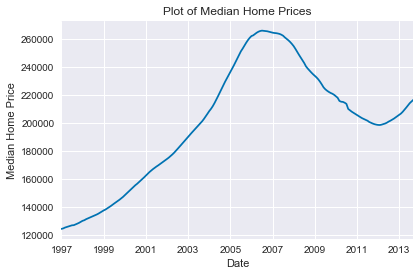

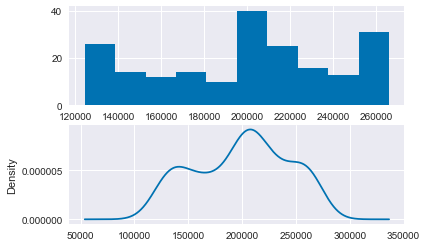

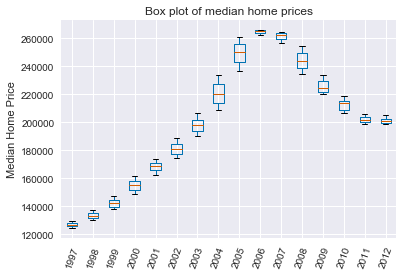

In [17]:
# 3.5.3) Data Analysis
series = Series.from_csv('dataset.csv', header = 0)

# a) summary statistics of time series
print(series.describe())

# b) line plot of time series
series.plot()
plt.title('Plot of Median Home Prices')
plt.ylabel('Median Home Price')
plt.tight_layout()
plt.show()

# c) density plots of time series
plt.figure(1)
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()

# d) boxplots of time series
groups = series['1997':'2012'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.title('Box plot of median home prices')
plt.ylabel('Median Home Price')
plt.xticks(rotation='70')
plt.show()

ADF Statistic: -2.423272
p-value: 0.135275
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


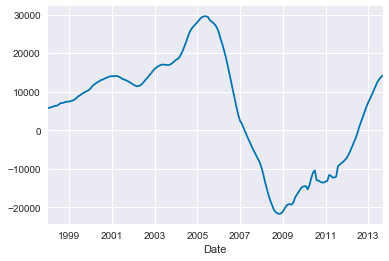

In [18]:
# 3.5.4) create and summarize stationary version of time series
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# Load the dataset
series = Series.from_csv('dataset.csv', header = 0)

X = series.values
X = X.astype('float32')

# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]

# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
# save
stationary.to_csv('stationary.csv')

# plot
stationary.plot()
plt.show()

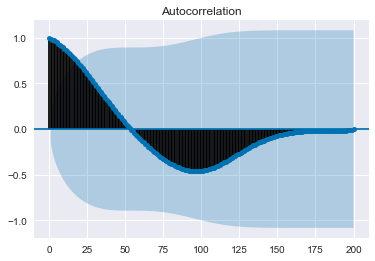

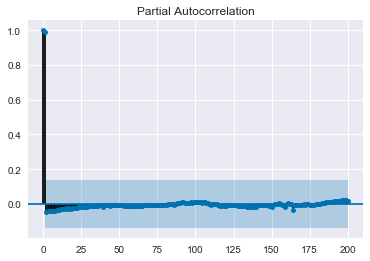

In [23]:
# 3.5.4) # ACF and PACF plots of time series
series = Series.from_csv('dataset.csv', header = 0)

plot_acf(series, ax=plt.gca())
plt.show()

plot_pacf(series, ax=plt.gca())
plt.show()

In [20]:
# 3.5.4) evaluate manually configured ARIMA model

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv', header = 0)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=214332.342, Expected=215072
>Predicted=214703.565, Expected=214490
>Predicted=214510.649, Expected=213655
>Predicted=213137.695, Expected=210073
>Predicted=206873.532, Expected=209100
>Predicted=208279.754, Expected=208107
>Predicted=207308.464, Expected=207307
>Predicted=206324.174, Expected=206548
>Predicted=205543.344, Expected=205784
>Predicted=204929.736, Expected=204842
>Predicted=202714.211, Expected=204134
>Predicted=204885.231, Expected=203401
>Predicted=203149.202, Expected=202767
>Predicted=201752.476, Expected=202221
>Predicted=201416.542, Expected=201637
>Predicted=198267.889, Expected=200728
>Predicted=202033.958, Expected=200150
>Predicted=199477.392, Expected=199607
>Predicted=199173.728, Expected=199158
>Predicted=198685.395, Expected=198857
>Predicted=198465.837, Expected=198643
>Predicted=198149.500, Expected=198587
>Predicted=198603.103, Expected=198848
>Predicted=198907.734, Expected=199223
>Predicted=199499.738, Expected=199656
>Predicted=199987.729, Ex

In [21]:
# 3.5.5) grid search ARIMA parameters for time series

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv', header = 0)

# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 7)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [22]:
# 3.5.6) summarize ARIMA forecast residuals
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv', header = 0)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6, 2, 1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
    
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)

print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


RMSE: 2278.682
               0
count    96.0000
mean    -13.4571
std    2290.6033
min   -9716.7868
25%    -916.6458
50%    -373.0738
75%    1324.1874
max    5001.7404


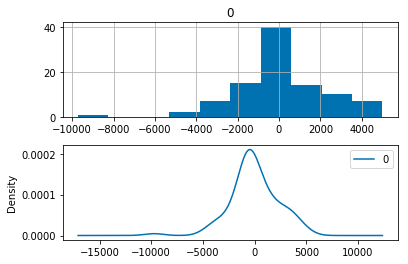

In [18]:
# 3.5.7) plots of residual errors of bias corrected forecasts
# Logic borrowed from DeptOneTimeSeries.ipynb sample provided by professor Jonathan Fox

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv', header = 0)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 87.6801 # Mean from the residual
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6, 2, 1)) # best ARIMA from grid search model
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


               0
count    96.0000
mean     74.2230
std    2290.6033
min   -9629.1067
25%    -828.9657
50%    -285.3937
75%    1411.8675
max    5089.4205


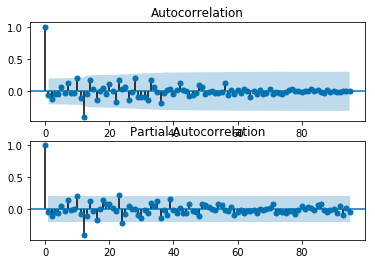

In [19]:
# 3.5.8) ACF and PACF plots of residual errors of bias corrected forecasts
# Logic borrowed from DeptOneTimeSeries.ipynb sample provided by professor Jonathan Fox

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv', header = 0)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6, 2, 1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

In [21]:
# 3.5.8) save finalized model
# Logic borrowed from DeptOneTimeSeries.ipynb sample provided by professor Jonathan Fox

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Load the dataset for modeling
series = Series.from_csv('dataset.csv', header = 0)

# prepare data
X = series.values
X = X.astype('float32')

# difference data
months_in_year = 12
diff = difference(X, months_in_year)

# fit model
model = ARIMA(diff, order=(6, 2, 1)) # Using the best RMSE
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual
bias = 74.2230 # Using the residual model mean as our bias

# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

In [23]:
# 3.5.9) load finalized model and make a prediction
# Logic borrowed from DeptOneTimeSeries.ipynb sample provided by professor Jonathan Fox

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# Load the dataset for prediction
series = Series.from_csv('dataset.csv', header = 0)

months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 179372.458


>Predicted=179372.458, Expected=177400
>Predicted=179288.286, Expected=176700
>Predicted=182547.364, Expected=182500
>Predicted=181044.658, Expected=180500
>Predicted=182700.432, Expected=185450
>Predicted=187161.295, Expected=183250
>Predicted=184135.570, Expected=182450
>Predicted=188673.277, Expected=184300
>Predicted=182983.332, Expected=185900
>Predicted=186134.730, Expected=187150
>Predicted=188813.107, Expected=187900
>Predicted=188692.682, Expected=185400
RMSE: 2531.913


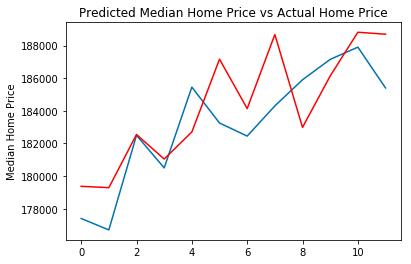

In [39]:
# 3.5.3.2) Validating Forecasts
# Logic borrowed from DeptOneTimeSeries.ipynb sample provided by professor Jonathan Fox

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('dataset.csv', header = 0)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv', header = 0)
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6, 2, 1)) # Using the mest ARIMA
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

pred_dates = ['2014-01','2014-02', '2014-03']
# Send the prediction to csv file    
#predictions.to_csv('predictions.csv')

# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red')
plt.title('Predicted Median Home Price vs Actual Home Price')
plt.ylabel('Median Home Price')
plt.show()

In [ ]:
# 3.3) Consolidate monthly data into an annual average.

In [ ]:
# 4 Answer the following questions:
# a) What three Zip codes provide the best investment opportunity for the SREIT?
# b) Why?

In [ ]:
# 5.1 Bonus: Develop a geographic visualization that in your view best depicts the data and recommendations:
# Logic borrow from https://www.kaggle.com/abigaillarion/police-fatalities-in-united-states
# a) Which states have reported the highest median home price given by 100,1000 of the population?
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

# Create a subset data frame of the dataset
population_data = df_final[['State', 'HomePrice','Population']]

print('\Top 5 observations')
print(population_data.head())

# States of interest only
us_states = np.asarray(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
                        'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
                        'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
                        'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
                        'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

# US states only, territories excluded.
population_data = population_data[population_data['State'].isin(us_states)]

# Median home price per 100,000 people in state
population_percapita = np.round(population_data.HomePrice / population_data.Population * 100000, 2)

# Create a collor scale for the visualization
color_scale = [[0, 'rgb(229, 239, 245)'], [1, 'rgb(1, 97, 156)']]

# Define the dataset
data = [dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = color_scale,
        showscale = False,
        locations = us_states,
        locationmode = 'USA-states',
        z = population_percapita,
        marker = dict(
            line = dict(
                color = 'rgb(255, 255, 255)',
                width = 2)
            ),
        )]

# Define the layout of the map
layout = dict(
         title = 'Median home price per 100,000 People in United States (1997-2013)',
         geo = dict(
             scope = 'usa',
             projection = dict(type = 'albers usa'),
             countrycolor = 'rgb(255, 255, 255)',
             showlakes = True,
             lakecolor = 'rgb(255, 255, 255)')
         )

# Display the final map
figure = dict(data = data, layout = layout)
iplot(figure)

In [ ]:
# 5.2 Bonus: Develop a geographic visualization that in your view best depicts the data and recommendations:
# Logic borrow from https://www.kaggle.com/abigaillarion/police-fatalities-in-united-states
# b) Median housing for December (state average)
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

# Create a subset data frame of the dataset
population_data = df_final[['State', 'HomePrice','Population']]

print('\Top 5 observations')
print(population_data.head())

# States of interest only
us_states = np.asarray(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
                        'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
                        'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
                        'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
                        'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

# US states only, territories excluded.
population_data = population_data[population_data['State'].isin(us_states)]
x
# Median home price per 100,000 people in state
population_percapita = np.round(population_data.HomePrice / population_data.Population * 100000, 2)

# Create a collor scale for the visualization
color_scale = [[0, 'rgb(229, 239, 245)'], [1, 'rgb(1, 97, 156)']]

# Define the dataset
data = [dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = color_scale,
        showscale = False,
        locations = us_states,
        locationmode = 'USA-states',
        z = population_percapita,
        marker = dict(
            line = dict(
                color = 'rgb(255, 255, 255)',
                width = 2)
            ),
        )]

# Define the layout of the map
layout = dict(
         title = 'Median home price per 100,000 People in United States (1997-2013)',
         geo = dict(
             scope = 'usa',
             projection = dict(type = 'albers usa'),
             countrycolor = 'rgb(255, 255, 255)',
             showlakes = True,
             lakecolor = 'rgb(255, 255, 255)')
         )

# Display the final map
figure = dict(data = data, layout = layout)
iplot(figure)